In [1]:
import os, code, sys, time
import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L 
import chainer.optimizers as optimizers
import chainer.serializers as serializers
from chainer import cuda
import cupy
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
from data_utils import *
import models, nn, graph_ops
'''
This notebook is for evaluating and visualizing results of trained models
'''

'\nThis notebook is for evaluating and visualizing results of trained models\n'

In [2]:
'''
Model labels
'''
PLOT_SAVE_DIR = './Visualizations/'
if not os.path.exists(PLOT_SAVE_DIR): os.makedirs(PLOT_SAVE_DIR)
model_loss_dir = './Data/Loss/'
RNG_SEEDS = [98765, 12345, 77743196]
trained_redshifts = ['0600', '1008']
trained_size = ['32']
model_tags = {'G':'graph', 'GL':'graph_theta', 'S':'set', 'SL':'set_theta', 'V':'vel'}
mname_placeholder = '{}_{}_{}_' # mtag_size_redshift_
loss_val_fname = 'val_loss.npy'
loss_train_fname = 'train_loss.npy'

def load_loss(dsize, redshift, val=False):
    loss_dict = {}
    lh_type = loss_val_fname if val else loss_train_fname
    for mtag, mlabel in model_tags.items():
        loss_fname = mname_placeholder.format(mtag, dsize, redshift) + lh_type
        loss_arr   = np.mean(np.load(model_loss_dir + loss_fname), axis=0)
        loss_dict[mlabel] = loss_arr
    return loss_dict   

In [3]:
'''
Load loss histories
'''
losses_tr_32_0600 = load_loss('32', '0600', val=False)
losses_va_32_0600 = load_loss('32', '0600', val=True)

losses_tr_32_1008 = load_loss('32', '1008', val=False)
losses_va_32_1008 = load_loss('32', '1008', val=True)

losses_tr_16_1510 = load_loss('16', '1510', val=False)
losses_va_16_1510 = load_loss('16', '1510', val=True)

In [9]:
'''
Plot utils
'''
def format_rsfloats(zx, zy):
    x = str(zx)
    x = x[0] + x[-1]
    y = str(zy)
    y = y[0] + y[-1]
    return x, y

def plot_loss(lh, subject, dparams, start_idx=0, smooth=False, val=False):
    assert subject in ['gra', 'set', 'all'] # 'gra': plot graph only, 'set': set only
    loss_subset = [] # list for subset of lh keys to plot
    if subject == 'all':
        loss_subset = list(lh.keys())
    else:
        for label in lh:
            trunc_label = label[:len(subject)]
            if trunc_label == subject or label == 'vel':
                loss_subset.append(label)
    if subject == 'gra': subject = 'graph'
    plt.close('all')
    plt.figure(figsize=(12,6))
    plt.grid(True)
    xlab = 'Batches' if val else 'Iterations'
    plt.xlabel(xlab)
    plt.ylabel('MSE')
    ptype = 'Validation' if val else 'Training'
    ptitle = '{} Error: {} models, {}, {} -> {}'.format(ptype, subject, dparams[0], dparams[1], dparams[2])
    plt.title(ptitle)
    for label in loss_subset:
        cur_loss = lh[label][start_idx:]
        label_num = np.mean(cur_loss) if val else np.median(cur_loss[-150:])
        plabel = '{: <12}: {:.8f}'.format(label, label_num)
        if smooth:
            iter_range = np.arange(cur_loss.shape[0]) # if you have weird stuff on smoothed plots, reevaluate this line
            poly = np.poly1d(np.polyfit(iter_range, cur_loss, 3))
            plt.plot(poly(iter_range), label=plabel)
        else:
            plt.plot(cur_loss, label=plabel)
    plt.legend()
    plt.tight_layout()
    zx, zy = format_rsfloats(dparams[1], dparams[2])
    fsname = '{}{}_{}_{}{}_{}'.format(PLOT_SAVE_DIR, subject, dparams[0], zx, zy, ptype)
    plt.savefig(fsname, bbox_inches='tight')

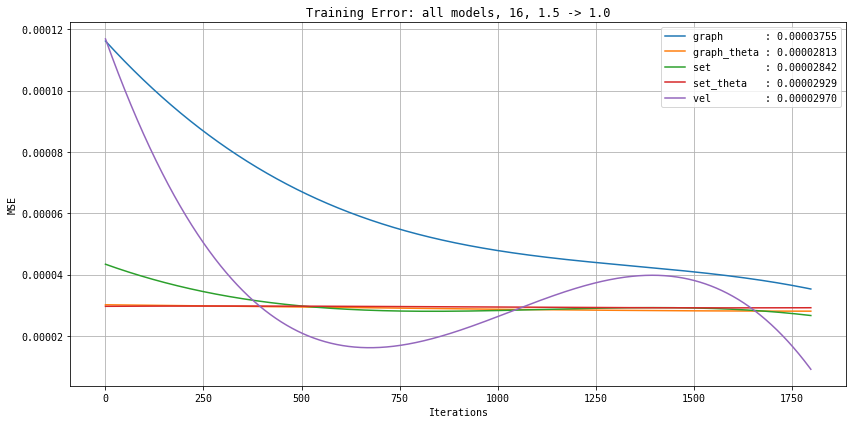

In [14]:
#def plot_loss(lh, subject, dparams, start_idx=0, smooth=False, val=False):
matplotlib.rc('font', family='monospace')

# 0.6 -> 0.0
plot_loss(losses_tr_32_0600, 'gra', (32, 0.6, 0.0), start_idx=200, smooth=True)
plot_loss(losses_tr_32_0600, 'set', (32, 0.6, 0.0), start_idx=200, smooth=True)
plot_loss(losses_tr_32_0600, 'all', (32, 0.6, 0.0), start_idx=200, smooth=True)

# 1.0 -> 0.8
plot_loss(losses_tr_32_1008, 'gra', (32, 1.0, 0.8), start_idx=200, smooth=True)
plot_loss(losses_tr_32_1008, 'set', (32, 1.0, 0.8), start_idx=200, smooth=True)
plot_loss(losses_tr_32_1008, 'all', (32, 1.0, 0.8), start_idx=200, smooth=True)

# 1.5 -> 1.0
plot_loss(losses_tr_16_1510, 'gra', (16, 1.5, 1.0), start_idx=200, smooth=True)
plot_loss(losses_tr_16_1510, 'set', (16, 1.5, 1.0), start_idx=200, smooth=True)
plot_loss(losses_tr_16_1510, 'all', (16, 1.5, 1.0), start_idx=200, smooth=True)

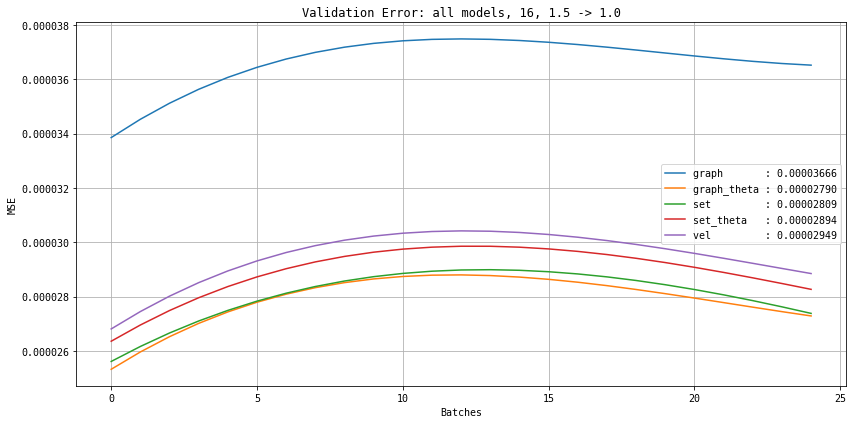

In [15]:
# 0.6 -> 0.0
plot_loss(losses_va_32_0600, 'gra', (32, 0.6, 0.0), start_idx=0, smooth=True, val=True)
plot_loss(losses_va_32_0600, 'set', (32, 0.6, 0.0), start_idx=0, smooth=True, val=True)
plot_loss(losses_va_32_0600, 'all', (32, 0.6, 0.0), start_idx=0, smooth=True, val=True)

# 1.0 -> 0.8
plot_loss(losses_va_32_1008, 'gra', (32, 1.0, 0.8), start_idx=0, smooth=True, val=True)
plot_loss(losses_va_32_1008, 'set', (32, 1.0, 0.8), start_idx=0, smooth=True, val=True)
plot_loss(losses_va_32_1008, 'all', (32, 1.0, 0.8), start_idx=0, smooth=True, val=True)

# 1.5 -> 1.0
plot_loss(losses_va_16_1510, 'gra', (16, 1.5, 1.0), start_idx=0, smooth=True, val=True)
plot_loss(losses_va_16_1510, 'set', (16, 1.5, 1.0), start_idx=0, smooth=True, val=True)
plot_loss(losses_va_16_1510, 'all', (16, 1.5, 1.0), start_idx=0, smooth=True, val=True)

In [6]:
'''
#=============================================================================
# From this cell below, making predictions when the previous model prediction 
#  is fed back as input.
#=============================================================================
'''
num_particles = 32
zX, zY = 0.6, 0.0
np.random.seed(12345)
X, Y = np.load('../X32_0600.npy'), np.load('../Y32_0600.npy')
#X, Y = data_utils.load_data(num_particles, zX, zY, normalize_data=True)

In [68]:
'''
Funs for finding most and least diff
'''
def get_bounded(x, bound):
    return np.all(np.logical_and(bound < x, x < 1-bound), axis=-1)

def bounded_mse(x,y, bound=0.095):
    x_loc = x[...,:3]
    y_loc = y[...,:3]
    bidx = get_bounded(y_loc, bound)
    bx = x_loc[bidx]
    by = y_loc[bidx]
    return np.mean(np.sum(np.square(bx - by), axis=-1))

def diff_sorted_idx(x, y, num_idx=4):
    num_samps = x.shape[0]
    diffs = np.zeros((num_samps))
    for i in range(num_samps):
        diffs[i] = bounded_mse(x[i], y[i])
    idx = np.argsort(diffs)
    #return idx
    least = list(idx[:num_idx])[::-1]
    most  = list(idx[-1:-(num_idx+1):-1])
    most.extend(least)
    return most

In [20]:
'''
Model evaluate predictions
'''
model_dir = './Data/Models/'
graph_channels = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 6] # for graph model
set_channels   = [6, 32, 128, 256, 128, 32, 256, 16, 6]

model = models.GraphModel(graph_channels)
serializers.load_npz(model_dir + 'VP_G_32_0600_77743196_.model', model)

In [21]:
'''
Split data into batches
'''
batch_idx = diff_sorted_idx(X,Y, num_idx=4) # first 4 are greatest diff, last 4 are least
xin, xtrue = X[batch_idx], Y[batch_idx]
x_in, x_true = chainer.Variable(xin), chainer.Variable(xtrue)

In [23]:
'''
Get predictions
'''
with chainer.using_config('train', False):
    x_hat   = model(x_in, add=True)
    x_rehat = model(x_hat, add=True)

In [24]:
'''
Save input, truth, and predictions
'''
pred_save_dir = './Samples/Data/DataBatches'
sname = 'VP_G_'
np.save(pred_save_dir + sname + 'input', xin)
np.save(pred_save_dir + sname + 'truth', xtrue)
np.save(pred_save_dir + sname + 'hat', x_hat.data)
np.save(pred_save_dir + sname + 'rehat', x_rehat.data)

In [ ]:
"""
Note: this script is in it's own directory because it uses a different
      virtualenv to manage mayavi/vtk dependencies

included here for convenience, if your you managed to make your way out of mayavi dependency hell
"""
import mayavi
from mayavi import mlab

def volumize_ptc(data_in, opacity=.5, labels=None, color=(1,0,0),frame=True, 
                 row=0, col=0, show=True, figure=None, proj=(False,True,True),
                 shadow=(False,True,True), mode='point', scale_factor=.015,
                 filename=None,):
    if figure is None:
        figure = mlab.figure(1, size=(400, 400), bgcolor=(0, 0, 0), fgcolor=(1, 0, 0))

    data = data_in.copy()
    data -= np.min(data, keepdims=True)
    data /= np.max(data, keepdims=True)
    data[:,0] += np.float(col)
    data[:,1] += np.float(row)
    xproj, yproj, zproj = proj
    xshadow, yshadow, zshadow = shadow
    if labels is None:
        pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
        #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
        #pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_mode='scalar', scale_factor=scale_factor)
        #pts = mlab.points3d(data[:,0], data[:,1], data[:,2], color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
    else:
        for l in np.unique(labels):
            color = tuple(list(np.random.rand(3)))
            ind = (labels == l).nonzero()[0]
            mlab.pipeline.volume(mlab.points3d(data[ind,0], data[ind,1], data[ind,2], 
                                               mode=mode, color=color, opacity=opacity))
    if frame:
        r_points = np.array([0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0]) + row + .0
        c_points = np.array([0,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1]) + col +.0
        d_points = np.array([0,0,0,0,1,1,1,0,0,1,1,1,0,0,1,1,0,0]) +.0
        mlab.plot3d(c_points, r_points, d_points, representation='surface',
                    tube_radius=.003, line_width=1, figure=figure, opacity=.7, color=(1,1,1))

    #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
    mlab.view(azimuth=20, elevation=70, distance=3, focalpoint=None, roll=None, reset_roll=True, figure=figure)    
    if filename is not None:
        mlab.savefig(filename, size=(500,500), figure=figure, magnification='auto') 
        if not show: mlab.clf()
    if show: mlab.show()



def volumize_arrow(datain,# n x 3
                   arrow, #nx3
                 opacity=.5, labels=None,
                 color=(1,0,0),
                 frame=True, row=0, col=0,
                 show=True,
                 figure=None,
                 proj=(False,True,True),
                 shadow=(False,True,True),
                 mode='point',
                 scale_factor=.001,
                 filename=None,
                 normalize=False,
):
    if figure is None:
        figure = mlab.figure(1, size=(400, 400), bgcolor=(0, 0, 0), fgcolor=(1, 0, 0))

    data = datain.copy()
    if normalize:
        data -= np.min(data, keepdims=True)
        data /= np.max(data, keepdims=True)
    data[:,0] += np.float(col)
    data[:,1] += np.float(row)
    xproj,yproj,zproj = proj
    xshadow,yshadow,zshadow=shadow
    if labels is None:
        #pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
        #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
        pts = mlab.quiver3d(data[:,0], data[:,1], data[:,2], arrow[:,0], arrow[:,1], arrow[:,2], color=color, opacity=opacity, figure=figure, mode=mode)
    else:
        for l in np.unique(labels):
            color = tuple(list(np.random.rand(3)))
            ind = (labels == l).nonzero()[0]
            mlab.pipeline.volume(mlab.points3d(data[ind,0], data[ind,1], data[ind,2], mode=mode, color=color, opacity=opacity))
    if frame:
        r_points = np.array([0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0]) + row + .0
        c_points = np.array([0,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1]) + col +.0
        d_points = np.array([0,0,0,0,1,1,1,0,0,1,1,1,0,0,1,1,0,0]) +.0
        mlab.plot3d(c_points, r_points, d_points, representation='surface',tube_radius=.003, line_width=1, figure=figure, opacity=.7, color=(1,1,1))


    #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
    mlab.view(azimuth=20, elevation=70, distance=3, focalpoint=None, roll=None, reset_roll=True, figure=figure)    
    if filename is not None:
        mlab.savefig(filename, size=(500,500), figure=figure, magnification='auto') 
        if not show:
            mlab.clf()
    if show:
        mlab.show()


# Note: 8 samples, with 0:3 having greatest difference betwen x_input_loc and x_truth_loc, and -1:-4 being least
j = 0 # sample,

model_name = 'VP_G_'

data_dir = './Data/DataBatches/'
x_input = np.load(data_dir + model_name + 'input.npy')
x_truth = np.load(data_dir + model_name + 'truth.npy')
x_hat   = np.load(data_dir + model_name + 'hat.npy')
x_rehat = np.load(data_dir + model_name + 'rehat.npy')

xtmp = x_input[j,:,:3]
bound = 0.1
lower, upper = bound, 1-bound 
mask1 = np.logical_and(xtmp[:,0] < upper, xtmp[:,0] > lower) 
mask2 = np.logical_and(xtmp[:,1] < upper, xtmp[:,1] > lower) 
mask3 = np.logical_and(xtmp[:,2] < upper, xtmp[:,2] > lower) 
mask = mask1 * mask2 * mask3
mask_nz = np.nonzero(mask)[0]

fig = mlab.figure(1, size=(400, 400), bgcolor=(1, 1, 1), fgcolor=(1, 0, 0))
red   = (1,0,0)
green = (0,1,0)
blue  = (0,0,1)
arrow_mode = 'arrow'
sfactor = .005

#arrow_true  = (x_input[j,mask_nz,:3],  x_truth[j,mask_nz,:3] - x_input[j,mask_nz,:3])
#arrow_input  = (x_input[j,mask_nz,:3],  x_input[j,mask_nz,3:])
arrow_pred   = (x_input[j,mask_nz,:3], x_hat[j,mask_nz,:3] - x_input[j,mask_nz,:3])
arrow_repred = (x_hat[j,mask_nz,:3], x_rehat[j,mask_nz,:3] - x_hat[j,mask_nz,:3])
#volumize_arrow(*arrow_true,  figure=fig, color=red,   opacity=.3, show=False, mode=arrow_mode)
#volumize_arrow(*arrow_input, figure=fig, color=green, opacity=.3, show=False, mode=arrow_mode)
volumize_arrow(*arrow_pred,   figure=fig, color=red,  opacity=.3, show=False,  mode=arrow_mode)
volumize_arrow(*arrow_repred,   figure=fig, color=blue,  opacity=.3, show=True,  mode=arrow_mode)

#volumize_ptc(x_truth[j,:,:3], show=False,figure=fig, opacity=.9, color=red,  mode='sphere', scale_factor=sfactor)
#volumize_ptc(x_input[j,:,:3], show=False,figure=fig, opacity=.9, color=green,mode='sphere', scale_factor=sfactor)
#volumize_ptc( x_hat[j,:,:3], show=True, figure=fig, opacity=.9, color=blue, mode='sphere', scale_factor=sfactor)